In [1]:
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./features.csv.zip
./notebook987ffe1208.ipynb
./sampleSubmission.csv.zip
./stores.csv
./test.csv.zip
./train.csv.zip
./.ipynb_checkpoints\notebook987ffe1208-checkpoint.ipynb


# **Import libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV,train_test_split

# **Training Data and Testing Data**

In [3]:
store = pd.read_csv("./stores.csv")
feature = pd.read_csv("./features.csv.zip")
train = pd.read_csv("./train.csv.zip")
test = pd.read_csv("./test.csv.zip")
sample = pd.read_csv("./sampleSubmission.csv.zip")

In [4]:
df_feature = pd.merge(store,feature,on=['Store'])
df_feature.info(),train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Type          8190 non-null   object 
 2   Size          8190 non-null   int64  
 3   Date          8190 non-null   object 
 4   Temperature   8190 non-null   float64
 5   Fuel_Price    8190 non-null   float64
 6   MarkDown1     4032 non-null   float64
 7   MarkDown2     2921 non-null   float64
 8   MarkDown3     3613 non-null   float64
 9   MarkDown4     3464 non-null   float64
 10  MarkDown5     4050 non-null   float64
 11  CPI           7605 non-null   float64
 12  Unemployment  7605 non-null   float64
 13  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(2), object(2)
memory usage: 903.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non

(None, None)

In [5]:
df_feature.Date = pd.to_datetime(df_feature.Date)
train.Date = pd.to_datetime(train.Date)
test.Date = pd.to_datetime(test.Date)

As Date column would not be understandable by model, we should label Date by week and year before creating test data and train data

In [6]:
df_feature['Week'] = df_feature.Date.dt.week 
df_feature['Year'] = df_feature.Date.dt.year

<ipython-input-6-f7e10db7150b>:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df_feature['Week'] = df_feature.Date.dt.week


In [7]:
df_train = pd.merge(train,df_feature,on=["Store","Date","IsHoliday"])
df_test = pd.merge(test,df_feature,on=["Store","Date","IsHoliday"])

In [8]:
df_train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Week,Year
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2010
1,1,2,2010-02-05,50605.27,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2010
2,1,3,2010-02-05,13740.12,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2010
3,1,4,2010-02-05,39954.04,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2010
4,1,5,2010-02-05,32229.38,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,5,2010


# **EDA**

Check null value percentage

In [9]:
df_train.isnull().mean()

Store           0.000000
Dept            0.000000
Date            0.000000
Weekly_Sales    0.000000
IsHoliday       0.000000
Type            0.000000
Size            0.000000
Temperature     0.000000
Fuel_Price      0.000000
MarkDown1       0.642572
MarkDown2       0.736110
MarkDown3       0.674808
MarkDown4       0.679847
MarkDown5       0.640790
CPI             0.000000
Unemployment    0.000000
Week            0.000000
Year            0.000000
dtype: float64

There is lot of null value in Markdown1-5. We will see if we could not find any relation, will drop them

**Lets see if we can find any relation for store type**

C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Store', ylabel='Size'>

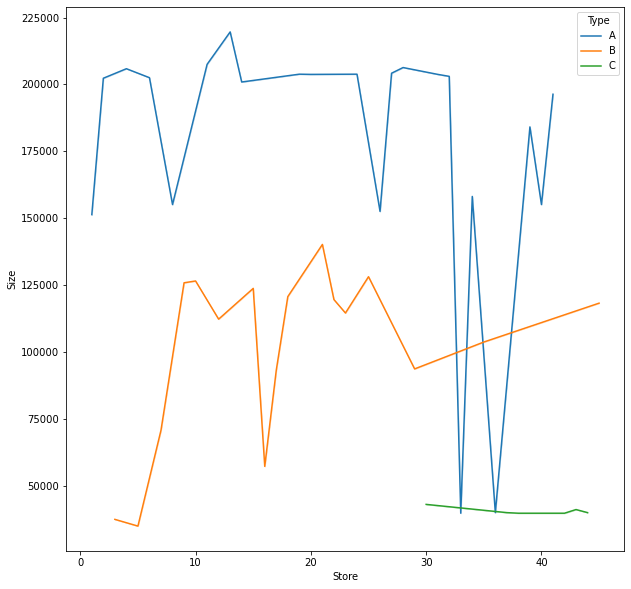

In [10]:
#sns.barplot(df_store.Type,df_store.Size,data=df_store)
plt.figure(figsize=(10,10))
sns.lineplot(df_train.Store,df_train.Size,data=df_train,hue=df_train.Type)


C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

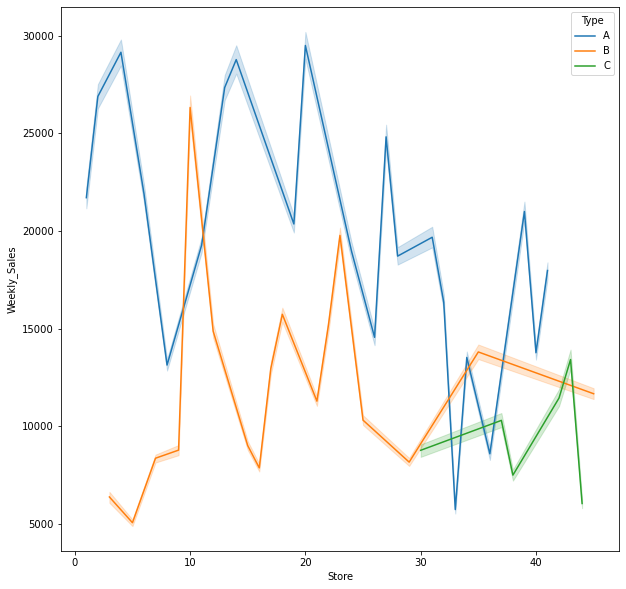

In [11]:
plt.figure(figsize=(10,10))
sns.lineplot(df_train['Store'],df_train['Weekly_Sales'],hue=df_train['Type'])

By looking at above graph, we can conclude that A>B>C in respective of sales and size 

In [12]:
df_train['Type'] = df_train['Type'].map({'A':3,'B':2,'C':1})
df_test['Type'] = df_test['Type'].map({'A':3,'B':2,'C':1})

C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\isham\anacond

<AxesSubplot:xlabel='MarkDown5', ylabel='Weekly_Sales'>

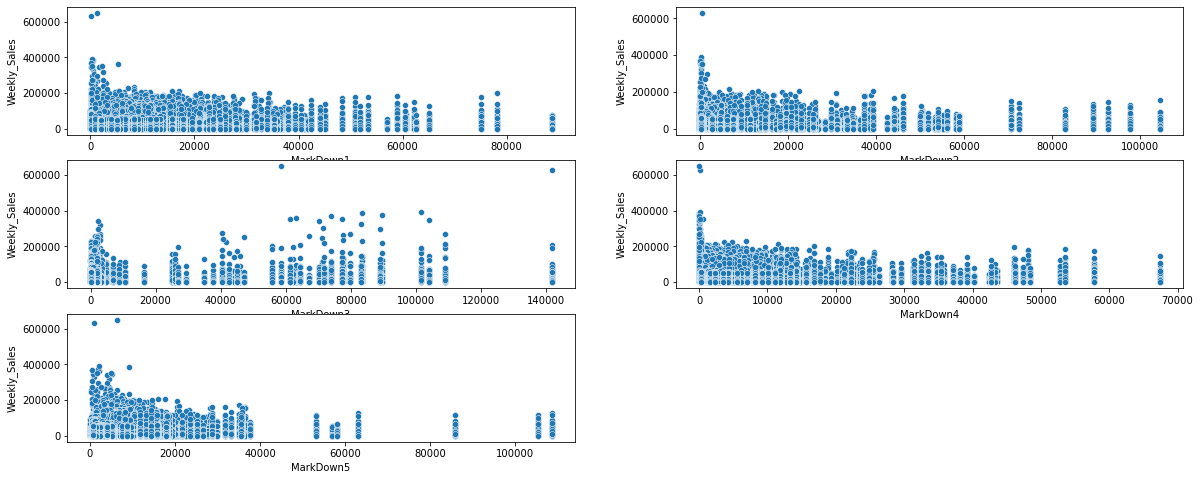

In [13]:
fig = plt.figure(figsize=(20,8))
plt.subplot(3,2,1)
sns.scatterplot(df_train['MarkDown1'],df_train['Weekly_Sales'])
plt.subplot(3,2,2)
sns.scatterplot(df_train['MarkDown2'],df_train['Weekly_Sales'])
plt.subplot(3,2,3)
sns.scatterplot(df_train['MarkDown3'],df_train['Weekly_Sales'])
plt.subplot(3,2,4)
sns.scatterplot(df_train['MarkDown4'],df_train['Weekly_Sales'])
plt.subplot(3,2,5)
sns.scatterplot(df_train['MarkDown5'],df_train['Weekly_Sales'])

Could not find any relation, will drop markdowns

In [14]:
df_train.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1,inplace=True)
df_test.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],axis=1,inplace=True)

<AxesSubplot:>

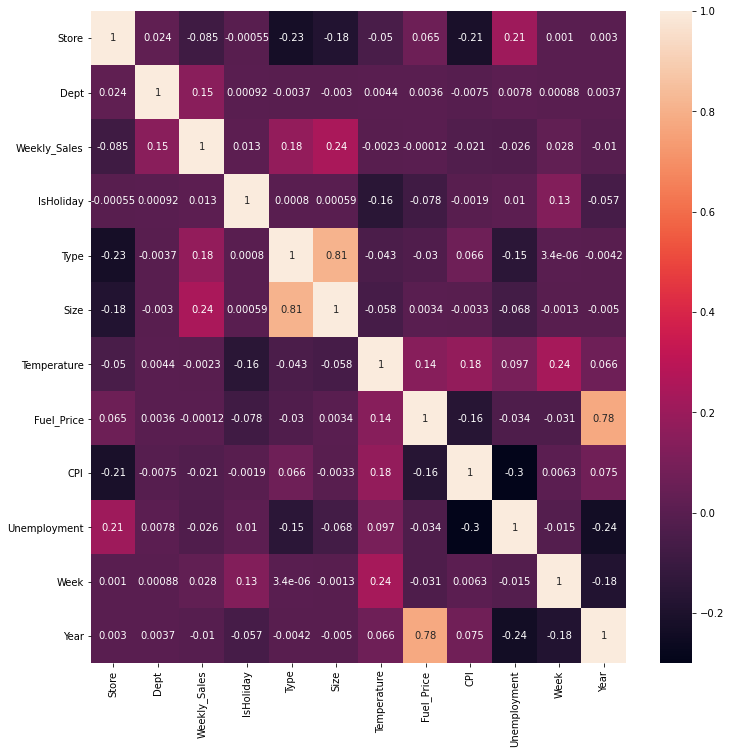

In [15]:
plt.figure(figsize=(12,12))
sns.heatmap(df_train.corr(),annot=True)

(Fuel_price, year) and (type, size) are related.
Conclusion - Drop Fuel_Price

In [16]:
df_train.drop(['Fuel_Price'],axis=1,inplace=True)
df_test.drop(['Fuel_Price'],axis=1,inplace=True)


Relation of IsHoliday ?


C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

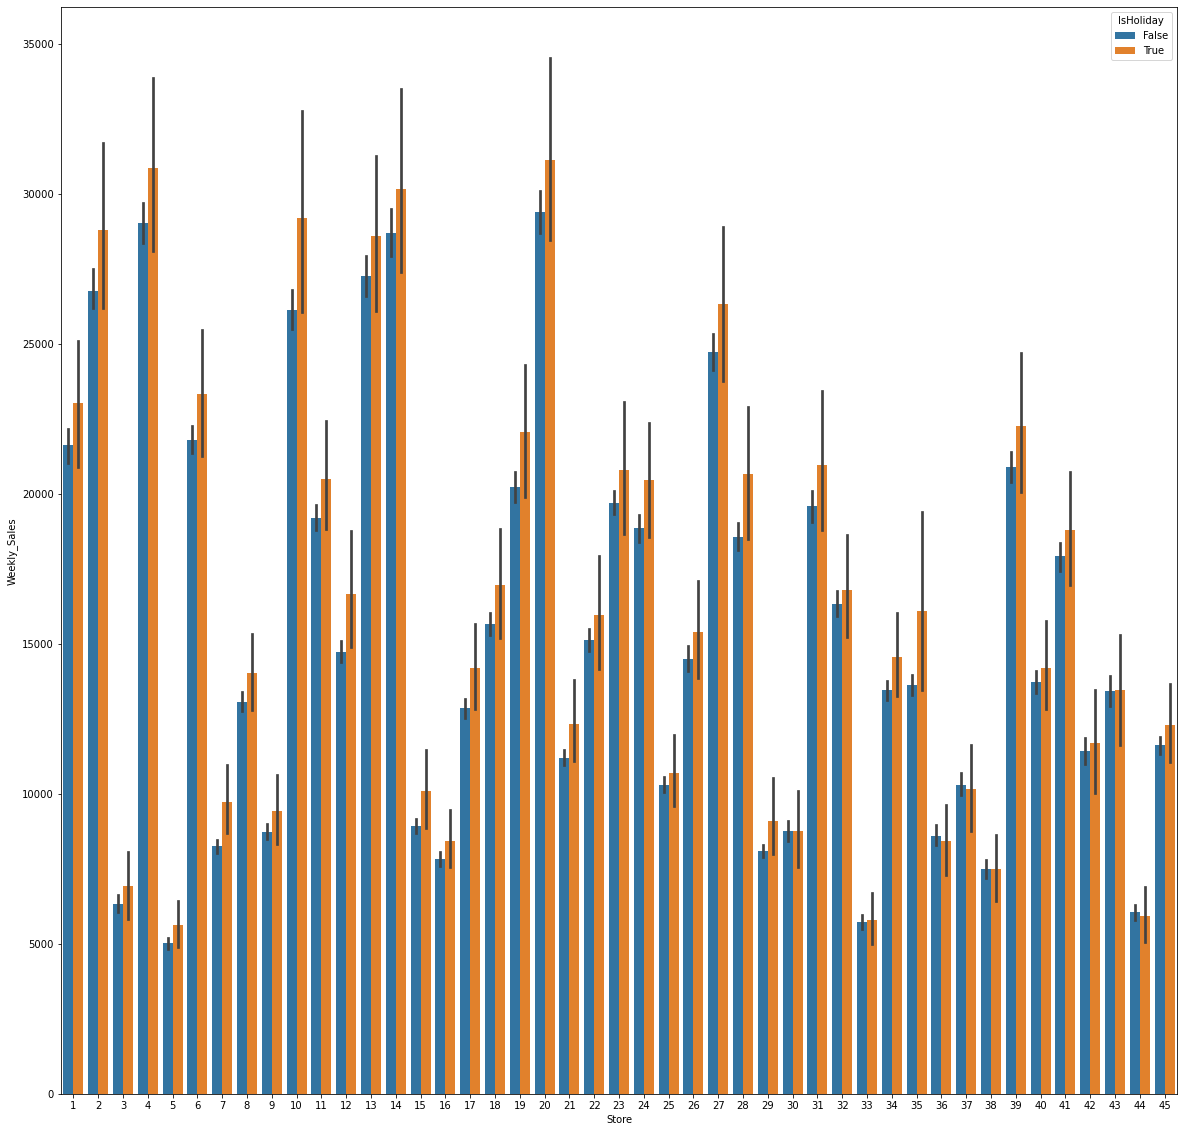

In [17]:
plt.figure(figsize=(20,20))
sns.barplot(df_train['Store'],df_train['Weekly_Sales'],hue=df_train['IsHoliday'])

C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

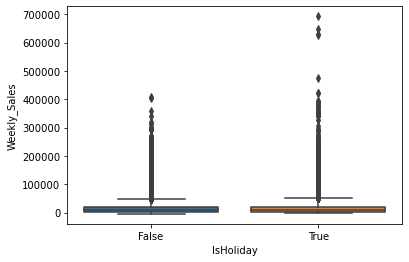

In [18]:
sns.boxplot(df_train['IsHoliday'],df_train['Weekly_Sales'])

We can see Sales is highly impacted by Holiday

C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\isham\anacond

<AxesSubplot:xlabel='Week', ylabel='IsHoliday'>

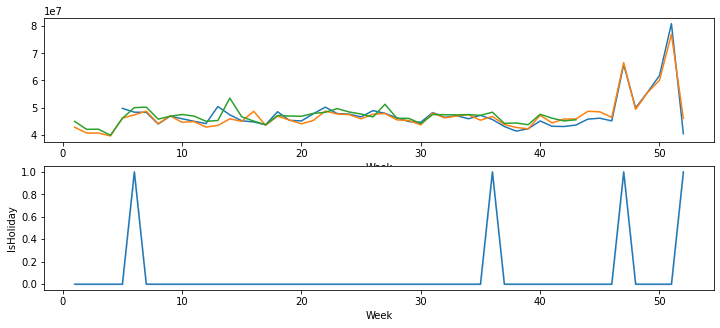

In [19]:
plt.figure(figsize=(12,5))
sale_2010 = df_train[df_train.Year==2010].groupby('Week')['Weekly_Sales'].sum()
sale_2011 = df_train[df_train.Year==2011].groupby('Week')['Weekly_Sales'].sum()
sale_2012 = df_train[df_train.Year==2012].groupby('Week')['Weekly_Sales'].sum()
plt.subplot(2,1,1)
sns.lineplot(sale_2010.index,sale_2010.values)
sns.lineplot(sale_2011.index,sale_2011.values)
sns.lineplot(sale_2012.index,sale_2012.values)
plt.subplot(2,1,2)
sns.lineplot(df_train.Week,df_train.IsHoliday)

It indicates that IsHoliday is highly correlated with Weekly Sales
Because of this, we should do cross validation and ensemble techniques

In [20]:
df_train['IsHoliday']=pd.get_dummies(df_train['IsHoliday'],drop_first=True)
df_test['IsHoliday']=pd.get_dummies(df_test['IsHoliday'],drop_first=True)

Lets see the performance of departments

C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Dept'>

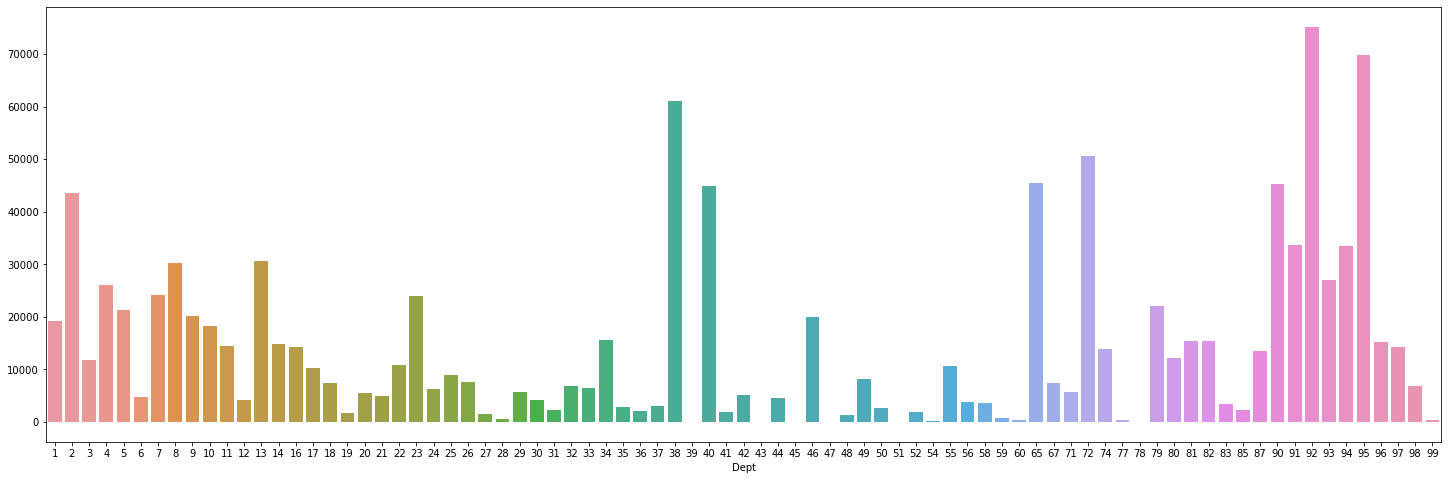

In [21]:
weekly_sales = df_train.groupby(df_train['Dept'])['Weekly_Sales'].mean()
plt.figure(figsize=(25,8))
sns.barplot(weekly_sales.index, weekly_sales.values)

We can see some departments are not performing well

Lets look at Temperature, CPI, Unemployment

C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\isham\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\isham\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings

<AxesSubplot:xlabel='Unemployment', ylabel='Density'>

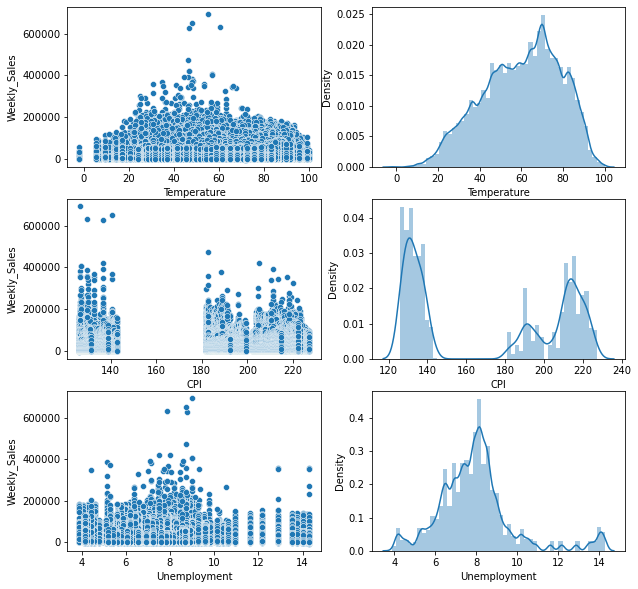

In [22]:
plt.figure(figsize=(10,10))
plt.subplot(3,2,1)
sns.scatterplot('Temperature','Weekly_Sales',data=df_train)
plt.subplot(3,2,2)
sns.distplot(df_train['Temperature'])
plt.subplot(3,2,3)
sns.scatterplot('CPI','Weekly_Sales',data=df_train)
plt.subplot(3,2,4)
sns.distplot(df_train['CPI'])
plt.subplot(3,2,5)
sns.scatterplot('Unemployment','Weekly_Sales',data=df_train)
plt.subplot(3,2,6)
sns.distplot(df_train['Unemployment'])


In [23]:
df_train.drop(['Temperature','Unemployment','CPI'],axis=1,inplace=True)
df_test.drop(['Temperature','Unemployment','CPI'],axis=1,inplace=True)

In [24]:
test_Date=df_test['Date']
df_train.drop(['Date'],axis=1,inplace=True)
df_test.drop(['Date'],axis=1,inplace=True)

In [25]:
x_train,x_test,y_train,y_test = train_test_split(df_train.drop(['Weekly_Sales'],axis=1),df_train['Weekly_Sales'],test_size=0.3)

In [26]:
clf = RandomForestRegressor()
clf.fit(x_train,y_train)
#param = {"n_estimators":[50,70,100,150,200],
    #"max_depth":[20,25,27],
   # "min_impurity_split":[1,2,3]}
#Search_CV = RandomizedSearchCV(clf,param,n_iter=5,n_jobs=-1,cv=5)
#Search_CV.fit(x_train,y_train)
#Search_CV.best_estimator_,Search_CV.best_score_

RandomForestRegressor()

In [27]:
y_pred=clf.predict(x_test)
#y_pred

In [28]:
print("testing score",clf.score(x_test,y_test))
print("training score",clf.score(x_train,y_train))

testing score 0.9711369110913161
training score 0.9970350105165782
